In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from env import get_db_url
import wrangle
from statistics import stdev
from sklearn.model_selection import train_test_split
from itertools import combinations, product, permutations
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import TweedieRegressor
import scipy.stats as stats

### Acquire
- Zillow data was pulled from Codeup's database utilizing a SQL query for single family homes with transcations in 2017.
- Looking at the dataset in MySQLWorkbench, many columns were missing data or had erroneous information.
- Information gathered was:
    - taxvaluedollarcnt(Tax_Appraised_Value - **target**)
    - bedroomcnt(Number_of_Bedrooms)
    - bathroomcnt(Number_of_Bathrooms)
    - calculatedfinishedsquarefeet(Square_Feet)
    - lotsizesquarefeet(Lot_Size)
    - yearbuilt(Year_Built)
    - fips(County_Code)
    - taxamount(Tax_Assessed)



In [2]:
df = wrangle.get_zillow_data()

### Prepare
  
   - Data cleaning:
   - drop nulls
   - Converted fips(County_Code) to counties
   - convert floats to integers except for Number_of_Bedrooms
   
   
   - Determine what a "home" should be considered in terms of beds, baths, square feet.
       - The data has been updated to include only home with greater than 1 bed, 1 bath, and a minimum of 120 sq. ft.
  
   - Outliers:
   - Approximately 5% of data dropped to exclude extreme outliers.
   - Values are:
       - 7 Beds
       - 7.5 Baths
       - 10,000 or less sq. feet
       - 20,000 or less sq. feet (lot size)
       - $3.5M or less in appraised value
   


In [3]:
# initial look at zillow df
df.head()

,Unnamed: 0,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County_Code,Lot_Size
0,0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0,4083.0
1,1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0,11975.0
2,2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0,9403.0
3,3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0,3817.0
4,4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0,9826.0


In [4]:
# dataset has over 2 million points of reference
df.shape

(2152863, 9)

In [5]:
df.isnull().mean()

Unnamed: 0             0.000000
Number_of_Bedrooms     0.000005
Number_of_Bathrooms    0.000005
Square_Feet            0.003941
Tax_Appraised_Value    0.000229
Year_Built             0.004337
Tax_Assessed           0.002063
County_Code            0.000000
Lot_Size               0.006242
dtype: float64

In [6]:
df = df.dropna()

In [7]:
#all data types are floats, will convert the majority to int
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129193 entries, 4 to 2152861
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   Number_of_Bedrooms   float64
 2   Number_of_Bathrooms  float64
 3   Square_Feet          float64
 4   Tax_Appraised_Value  float64
 5   Year_Built           float64
 6   Tax_Assessed         float64
 7   County_Code          float64
 8   Lot_Size             float64
dtypes: float64(8), int64(1)
memory usage: 162.4 MB


In [8]:
# convert floats to int except tax assesed and bathrooms
df['Year_Built'] = df['Year_Built'].astype(int)
df['Square_Feet'] = df['Square_Feet'].astype(int)
df['Number_of_Bedrooms'] = df['Number_of_Bedrooms'].astype(int)
df['Tax_Appraised_Value'] = df['Tax_Appraised_Value'].astype(int)
df['Lot_Size'] = df['Lot_Size'].astype(int)

In [9]:
# what should the minimum square footage be? 120 
# https://worldpopulationreview.com/state-rankings/minimum-house-size-by-state
# what percentage of homes under 120 sq ft are in the df?
round(len(df[df['Square_Feet']< 120])/ df.shape[0],4)

0.0001

In [10]:
# how many homes have no bedrooms?
len(df[df['Number_of_Bedrooms']==0])

4265

In [11]:
# bathrooms?
len(df[df['Number_of_Bathrooms']==0])

4212

In [12]:
# dropping rows that don't meet minimum home requirements (1 bed 1 bath > 120sq ft)
df = df[df.Square_Feet >120]
df = df[df.Number_of_Bedrooms >0]
df = df[df.Number_of_Bathrooms >.5]

In [13]:
# value counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-----------------")

Unnamed: 0
4          1
1435189    1
1435219    1
1435218    1
1435217    1
          ..
717565     1
717564     1
717563     1
717562     1
2152861    1
Name: Unnamed: 0, Length: 2123966, dtype: int64
-----------------
Number_of_Bedrooms
3     959490
4     630087
2     331870
5     149315
6      24775
1      22154
7       4731
8       1082
9        279
10       113
11        32
13        15
12        11
15         4
14         3
16         2
18         2
25         1
Name: Number_of_Bedrooms, dtype: int64
-----------------
Number_of_Bathrooms
2.00     939643
3.00     419158
1.00     410224
2.50     142665
4.00      80308
1.50      31014
3.50      28416
5.00      27440
4.50      19458
6.00      10366
5.50       6197
7.00       4255
8.00       1638
6.50       1327
9.00        682
7.50        379
10.00       311
11.00       143
8.50        108
12.00        69
9.50         49
13.00        36
14.00        23
10.50        14
15.00        14
16.00         8
1.75          3
17.00         3
12

In [14]:
df = wrangle.prepare_zillow_data(df)

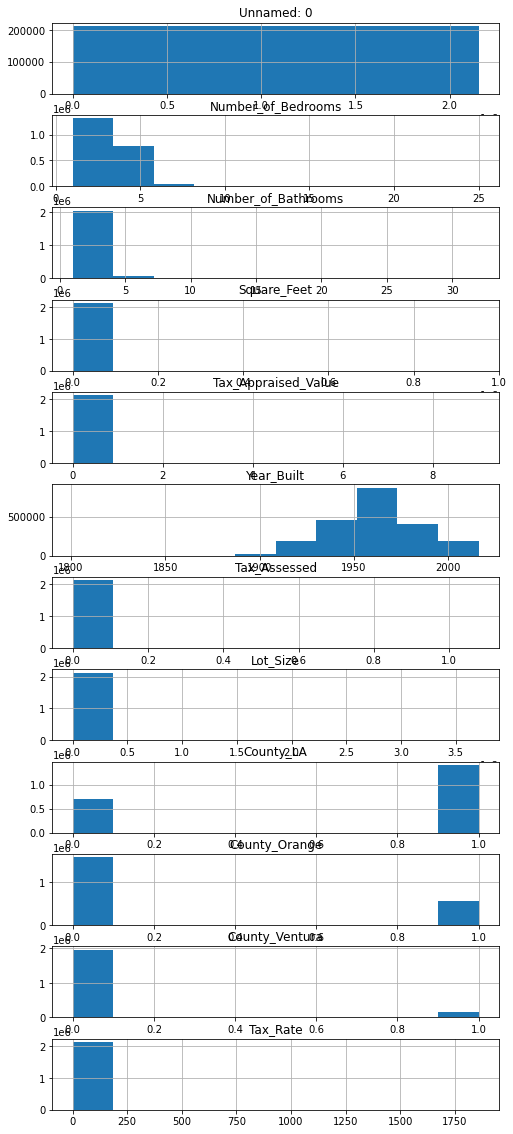

In [15]:
# let's look at the data via a histogram
fig, axis = plt.subplots(12,1,figsize=(8, 20))
df.hist(ax=axis)
plt.show()

**Takeaways:**
   - Number of bedrooms right_skewed, with the majority of bedrooms less than ~6.
   - Number of bathrooms is right-swkewed with the majority less than ~ 4.
   - Square feet is right-skewed with the majority of homes under 4000 sq feet.
   - Tax Appraised Value is right-skewed with the majority of homes under $1M.
   - Year built is normally distributed with the majority of homes being built right after 1950.
   - Lot size is normal-ish with right skewdness, majority of homes under 10000 sq feet.
   - *Need to handle outliers*

**Handling outliers**
The majority of customers are not going to be purchasing exorbitant homes.
   - Dataset adjusted to remove outliers.
   - Max bath = 7.5, max bed = 7, max appraised value = 3.5M, max sq. feet = 10,000, max lot size = 20,000

In [18]:
# the majority of homes are being appraised for 450K, what's the minimum value? $23??? let's adjust the min to 50k
df.Tax_Appraised_Value.min()

23

In [19]:
# removing signifcant outliers leaves ~92% of data.
df[(df.Tax_Appraised_Value>3_500_000) | (df.Tax_Appraised_Value<=50_000) | (df.Number_of_Bathrooms >7.5) | (df.Number_of_Bedrooms >7) | (df.Square_Feet >10000) | (df.Lot_Size>20000)].shape[0]/df.shape[0]

0.07981154123936071

In [20]:
df = wrangle.handle_outliers(df)

In [21]:
# we still hold close to 2 million datapoints
df.shape

(1954450, 13)

In [22]:
df.head()

,Unnamed: 0,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,Lot_Size,County_LA,County_Orange,County_Ventura,Tax_Rate
4,4,4,2.0,3633,296425,2005,6941.39,LA,9826,1,0,0,2.34
7,7,3,2.0,2077,646760,1926,7924.68,LA,6490,1,0,0,1.23
18,18,3,1.0,1244,169471,1950,2532.88,LA,6021,1,0,0,1.49
19,19,3,2.0,1300,233266,1950,3110.99,LA,4917,1,0,0,1.33
20,20,3,2.0,1222,290492,1951,3870.25,LA,5500,1,0,0,1.33


### Explore

    - Questions to answer:
        - Does bed, bath, square feet relate to tax value? Add lot size, with time.
        - Does year built affect the tax value?
        - What does county, tax rate have to do with value?
        

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1954450.0,1.076431e+06,621436.211868,4.00,538202.25,1076106.50,1614634.75,2152861.00
Number_of_Bedrooms,1954450.0,3.294085e+00,0.879156,1.00,3.00,3.00,4.00,7.00
Number_of_Bathrooms,1954450.0,2.196614e+00,0.867467,1.00,2.00,2.00,3.00,7.50
Square_Feet,1954450.0,1.792609e+03,762.000130,127.00,1264.00,1610.00,2142.00,9946.00
Tax_Appraised_Value,1954450.0,4.171734e+05,363158.723080,50000.00,197172.00,327671.00,517881.00,3500000.00
Year_Built,1954450.0,1.960764e+03,21.635998,1801.00,1949.00,1958.00,1974.00,2016.00
Tax_Assessed,1954450.0,5.119427e+03,4194.461359,16.48,2631.83,4102.90,6217.02,113530.05
Lot_Size,1954450.0,7.246157e+03,2946.897704,104.00,5585.00,6657.00,8096.00,20000.00
County_LA,1954450.0,6.560874e-01,0.475012,0.00,0.00,1.00,1.00,1.00
County_Orange,1954450.0,2.702868e-01,0.444108,0.00,0.00,0.00,1.00,1.00


In [24]:
train, validate, test = wrangle.split_zillow_data(df)
# split into train, validate, test before exploration

In [25]:
train.shape, validate.shape, test.shape

((1094492, 13), (469068, 13), (390890, 13))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Homes on Zillow by County')

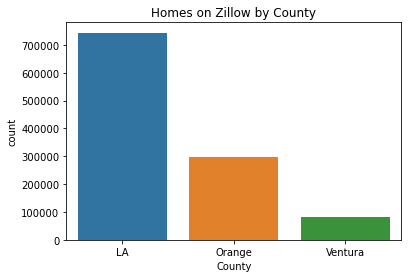

In [20]:
sns.countplot(train.County)
plt.title('Homes on Zillow by County')

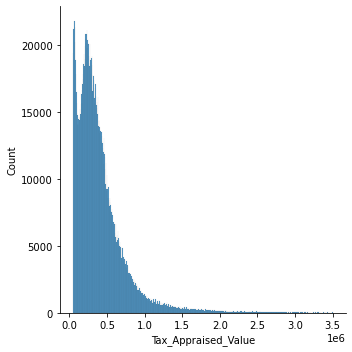

In [28]:
# visualize distibution of target variable 
sns.displot(df.Tax_Appraised_Value)

**Takeaways:**
  - Heatmaps show strongest correlation between number of bathrooms, number of bedrooms, and square feet.
  - Tax Appraised Value is most strongly correlated with square feet in overall, and in all 3 counties seperately.
 
  

<AxesSubplot:>

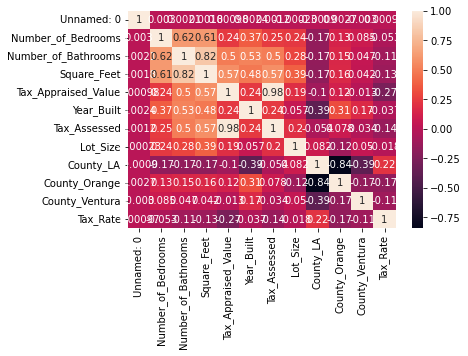

In [26]:
sns.heatmap(train.corr(),annot=True)
# in all three counties, highest correlation bewtween number of bedrooms to number of bathrooms and square feet, 
# square feet correlated to tax appraised value

Hypothesis test: 
Null: There is no relationship between tax appraised value and square feet
Alternative: There is a relationship between tax appraised value and square feet

In [13]:
alpha = .05
observed = pd.crosstab(train.Tax_Appraised_Value.sample(10000), train.Square_Feet.sample(10000))

In [14]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.24283227638465774

Hypothesis test: 
Null: There is no relationship between bedrooms and square feet
Alternative: There is a relationship between bedrooms and square feet

In [15]:
alpha = .05
observed = pd.crosstab(train.Number_of_Bedrooms.sample(10000), train.Square_Feet.sample(10000))

chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.40620108706311986

Hypothesis test: 
Null: There is no relationship between bathrooms and bedrooms
Alternative: There is a relationship between bathrooms and bedrooms

In [17]:
alpha = .05
observed = pd.crosstab(train.Number_of_Bathrooms.sample(10000), train.Number_of_Bedrooms.sample(10000))

In [18]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

2.2332296953395495e-07

In [19]:
train.County.value_counts(normalize=True)
# 66% of homes are in LA county

LA         0.661716
Orange     0.265006
Ventura    0.073278
Name: County, dtype: float64

In [23]:
LA, Orange, Ventura = wrangle.create_county_db(df)

<AxesSubplot:>

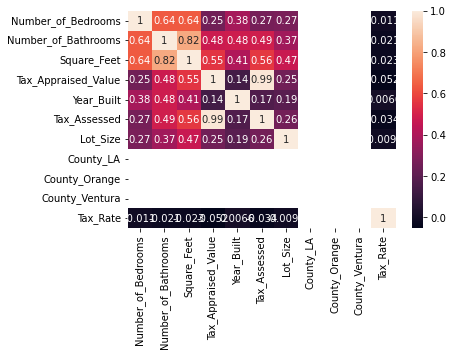

In [24]:
sns.heatmap(LA.corr(),annot=True)
#  LA county's highest correlation to tax appraisal is square feet (outside of tax ammount)

<AxesSubplot:>

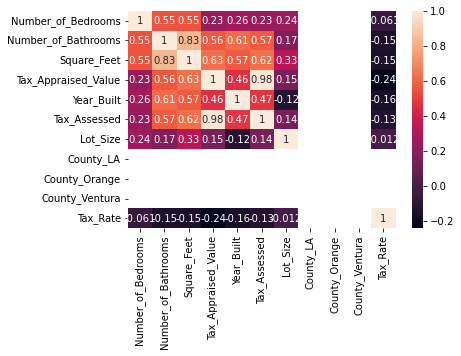

In [25]:
sns.heatmap(Orange.corr(),annot=True)
# Orange county's highest coorelation to tax appraisal is square feet (outside of tax ammount)

<AxesSubplot:>

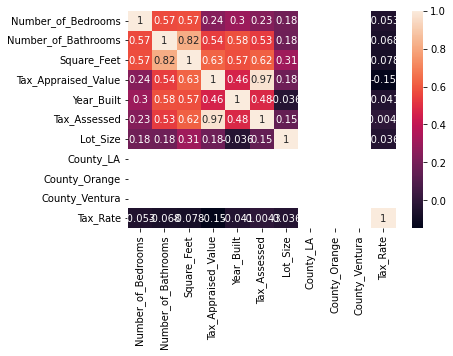

In [26]:
sns.heatmap(Ventura.corr(),annot=True)
# Ventura county's highest coorelation to tax appraisal is square feet (outside of tax ammount)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


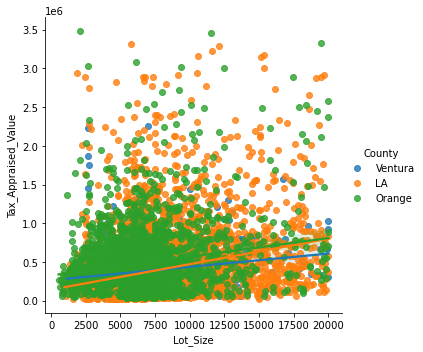

In [27]:
sns.lmplot('Lot_Size', 'Tax_Appraised_Value', data=train.sample(10000), scatter=True, hue='County', col=None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


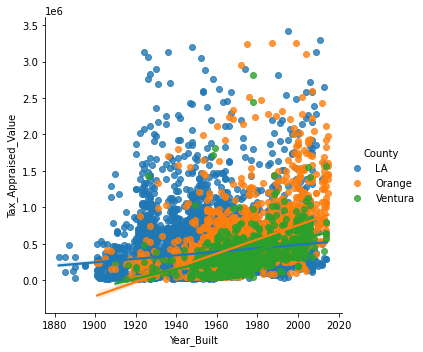

In [28]:
sns.lmplot('Year_Built','Tax_Appraised_Value', data=train.sample(10000), scatter=True, hue='County', col=None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


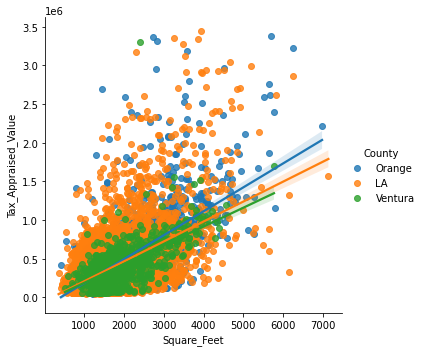

In [29]:
sns.lmplot('Square_Feet', 'Tax_Appraised_Value',data=train.sample(10000), scatter=True, hue='County', col=None)

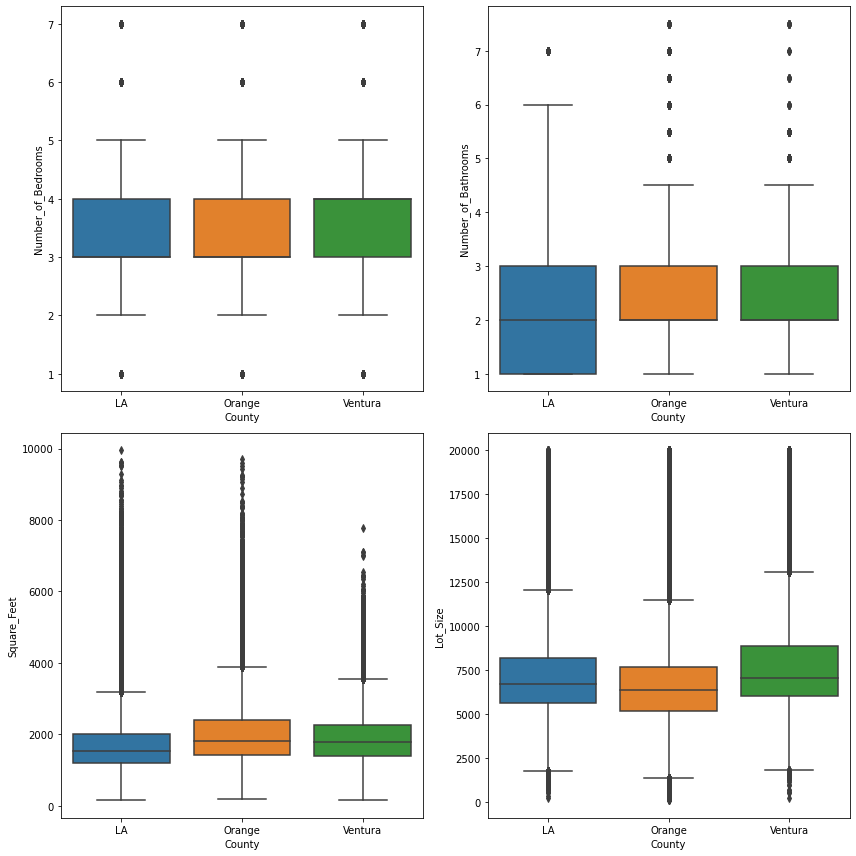

In [30]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Number_of_Bedrooms)
plt.subplot(2,2,2)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Number_of_Bathrooms)
plt.subplot(2,2,3)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Square_Feet)
plt.subplot(2,2,4)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Lot_Size)
plt.tight_layout()
plt.show()

Perform Chi-Squared test on relationships between bed, bath, sq. ft, lot size and Tax Appraised Value
Null: There is no relationship between square feet and tax appraised value
Alternative: There is a relationship between square feet and tax appraised value

aplha = .05

**Notes:** 
- Orange County has a higher median tax appraised value with a higher distribution of homes valued over 1M. 
- Ventura county has more outliers than both the other counties around 3.5M but otherwise is more compactly distributed at less than 1M.

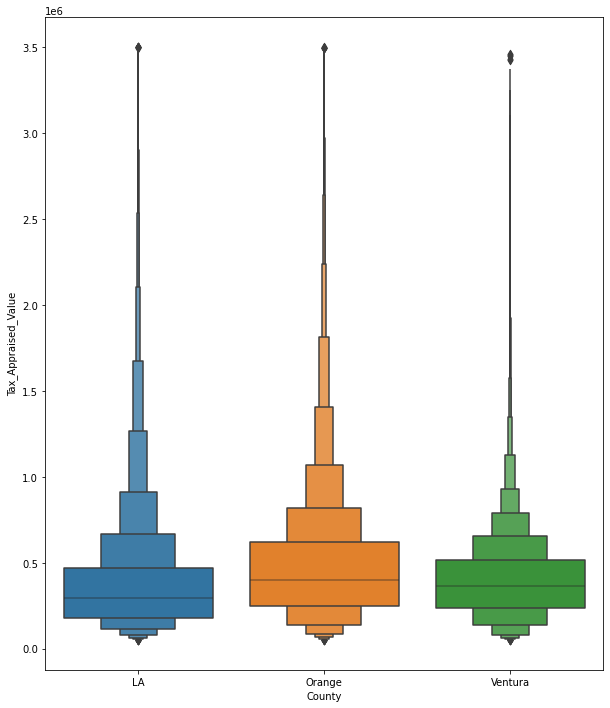

In [31]:
plt.figure(figsize=(10,12))
sns.boxenplot(data=train, y=train.Tax_Appraised_Value, x=train.County)
plt.show()

**ANOVA TEST:**
- Null Hypothesis: Tax Appraised Value is equal across all counties.
- Alternative Hypothesis: Tax Appraised Value is not equal across all counties.

In [ ]:
alpha = .05

In [ ]:
stats.f_oneway(LA['Tax_Appraised_Value'], Orange['Tax_Appraised_Value'], Ventura['Tax_Appraised_Value'])

### Scaling
 - will model with scaled and unscaled data
 - scaled to normalize and reduce the weight the of remaining outliers

In [ ]:
columns_to_scale = ['Number_of_Bedrooms','Number_of_Bathrooms', 'Square_Feet', 'Lot_Size']

#### Quantile Scaling

In [ ]:
scaler = sklearn.preprocessing.QuantileTransformer(output_distribution='normal')
train_scaled = train.copy()
train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])

In [ ]:
plt.figure(figsize=(10, 6))
train_scaled.hist()
plt.show()

#### Min Max Scaling

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
train_scaled_MM = train.copy()
train_scaled_MM[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
train_scaled_SS = train.copy()
train_scaled_SS[columns_to_s] = scaler.fit_transform(train_scaled_SS[train])


### Modeling 

**Establish a baseline**

In [ ]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [29]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

NameError: name 'y_train' is not defined

In [30]:
y_train['TAV_pred_mean'] = round(train.Tax_Appraised_Value.mean(),2)
y_validate['TAV_pred_mean'] = round(train.Tax_Appraised_Value.mean(),2)

NameError: name 'y_train' is not defined

In [ ]:
y_train['TAV_pred_median'] = round(train.Tax_Appraised_Value.median(),2)
y_validate['TAV_pred_median'] = round(train.Tax_Appraised_Value.median(),2)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

**Takeaways:** Out-of-sample data performs better than in-sample; model is not overfit. Using the mean is slightly better. 

#### Ordinary Least Squares Modeling

 - using bath, bed, square feet

In [ ]:
X_train.head()

In [ ]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_test = test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
# create the model
lm = LinearRegression(normalize=True)

In [ ]:
# fit the model
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
# train the model
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
# evaluate RMSE
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

- Using bath, bed, square feet, year built, and lot size

In [ ]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [ ]:
train.head(1)

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
# create the model
lm = LinearRegression(normalize=True)

In [ ]:
# fit the model
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
# train the model
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
# evaluate RMSE
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

**Using quantile scaled data**

In [ ]:
X_train = train_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_test = test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm_scaled'] = lm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

**Using Min Max scaled data**

In [ ]:
X_train = train_scaled_MM.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_test = test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm_scaled_MM'] = lm.predict(X_train)

In [ ]:
rmse_train_MM = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled_MM)**(1/2)
print('RMSE in Sample: ', round(rmse_train_MM,2))

### Tweedie Regressor Modeling

In [ ]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
# create the model
glm = TweedieRegressor(power=0, alpha=1)

In [ ]:
# fit the model
glm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_glm'] = glm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_glm)**(1/2)
print('Tweedie-RMSE in Sample: ', round(rmse_train,2))

#### Using scaled data

In [ ]:
X_train = train_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
# create the model
glm = TweedieRegressor(power=0, alpha=1)

In [ ]:
glm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_glm_scaled'] = glm.predict(X_train)

In [ ]:
rmse_train_scaled = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_glm_scaled)**(1/2)
print('Tweedie-RMSE in Sample: ', round(rmse_train_scaled,2))

In [ ]:
df.head()

In [ ]:
dummy_df = pd.get_dummies(df[['County']],dummy_na=False, drop_first=False)
df = pd.concat([df, dummy_df], axis=1)

In [ ]:
df.head(1)

In [ ]:
train,validate,test = wrangle.split_zillow_data(df)

train on each county

In [ ]:
LA = df[df.County == 'Los Angeles']
Orange = df[df.County == 'Orange']
Ventura = df[df.County == 'Ventura']

In [ ]:
LA_train, LA_validate, LA_test = wrangle.split_zillow_data(LA)

In [ ]:
LA_train.shape, LA_validate.shape

In [ ]:
X_train = LA_train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = LA_train['Tax_Appraised_Value']

X_validate = LA_validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = LA_validate['Tax_Appraised_Value']

X_test = LA_test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = LA_test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

In [ ]:
Orange_train, Orange_validate, Orange_test = wrangle.split_zillow_data(Orange)

In [ ]:
X_train = Orange_train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = Orange_train['Tax_Appraised_Value']

X_validate = Orange_validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = Orange_validate['Tax_Appraised_Value']

X_test = Orange_test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = Orange_test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

In [ ]:
Ventura_train, Ventura_validate, Ventura_test = wrangle.split_zillow_data(Ventura)

In [ ]:
X_train = Ventura_train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = Ventura_train['Tax_Appraised_Value']

X_validate = Ventura_validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = Ventura_validate['Tax_Appraised_Value']

X_test = Ventura_test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = Ventura_test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))